In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#%config InlineBackend.figure_format = 'pdf'

import kgof
import kgof.data as data
import kgof.density as density
import kgof.goftest as gof
import kgof.kernel as kernel
import kgof.util as util
import matplotlib
import matplotlib.pyplot as plt
import autograd.numpy as np
import scipy.stats as stats
import tensorflow as tf

In [2]:
# font options
font = {
    #'family' : 'normal',
    #'weight' : 'bold',
    'size'   : 18
}

plt.rc('font', **font)
plt.rc('lines', linewidth=2)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Shapiro-Wilk

In [3]:
# Can it work for the multivariate case?
#x = np.random.randn(200, 2).dot(np.random.rand(2, 2)) + 3
x = stats.t.rvs(df=5, size=500) 
st, pval = stats.shapiro(x)
print 'stat: {0}, pval: {0}'.format( st, pval)

stat: 0.977645576, pval: 0.977645576


## Anderson-Darling

In [4]:
result =  stats.anderson(x, dist='norm')
result

AndersonResult(statistic=2.614600187209021, critical_values=array([ 0.571,  0.651,  0.781,  0.911,  1.083]), significance_level=array([ 15. ,  10. ,   5. ,   2.5,   1. ]))

In [5]:
A = np.reshape(range(12), (4, 3))
A

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [6]:
A*np.random.randn(3)

array([[ -0.        ,   0.46625675,  -0.50478007],
       [ -4.66824543,   1.86502698,  -1.26195018],
       [ -9.33649086,   3.26379722,  -2.01912029],
       [-14.00473629,   4.66256746,  -2.7762904 ]])

## Hashing function handles

In [7]:
f1 = lambda x: x**2
hash(f1.__code__)

941130003640358038

In [8]:
class Func(object):
    def __call__(self, x):
        return x**3

f2 = Func()
f2(2)

8

In [9]:
hash(f2)

8793572282521

In [10]:
import pickle
iso = density.IsotropicNormal(np.zeros(2), 1)

## Test autograd

In [11]:
import autograd as ag
#import numpy as np
import autograd.numpy as np

def kgauss(X, Y, sigma2=1):
    sumx = np.sum(X**2, 1)
    sumy = np.sum(Y**2, 1)
    D2 = sumx.reshape(-1, 1) - 2*X.dot(Y.T) + sumy.reshape(1, -1)
    K = np.exp(-D2/(2.0*sigma2))
    return K

def exp(X):
    Y = X
    d = {'a': Y}
    return np.exp(-d['a'])[0, :]

In [12]:
n = 3
d = 2
X = np.random.randn(n, d)

#K = kgauss(X, X)
#g_kg = ag.grad(kgauss)
#g_kg(X, X)

E = exp(X)
g_exp = ag.elementwise_grad(exp)
j_exp = ag.jacobian(exp)

In [13]:
E

array([ 0.40831223,  0.71494586])

In [14]:
g_exp(X)

array([[-0.40831223, -0.71494586],
       [-0.        , -0.        ],
       [-0.        , -0.        ]])

In [15]:
j_exp(X)

array([[[-0.40831223, -0.        ],
        [-0.        , -0.        ],
        [-0.        , -0.        ]],

       [[-0.        , -0.71494586],
        [-0.        , -0.        ],
        [-0.        , -0.        ]]])

## Test autograd with instance variables

In [16]:
import autograd
import autograd.numpy as np
import copy

In [17]:
seed = 8
mean = np.zeros(d)
variance = 1
isonorm = density.IsotropicNormal(mean, variance)

# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
draw_mean = mean +0
draw_variance = variance + 1
X = util.randn(n, d, seed=seed)*np.sqrt(draw_variance) + draw_mean
dat = data.Data(X)


In [18]:
def optimize_obj(p, data, k_cls, k_params, V0):
    k = k_cls.from_params(**k_params)
    fssd = gof.FSSD(p, k, V0, seed=seed+1)
    fea_tensor = fssd.feature_tensor(X)
    u_mean, u_variance = gof.FSSD.ustat_h1_mean_variance(fea_tensor, return_variance=True)
    # mean/sd criterion 
    obj = u_mean/np.sqrt(u_variance)
    return obj

In [19]:
J = 3
sig2 = util.meddistance(X, subsample=1000)**2
k_params = {'sigma2': sig2}
#k = kernel.KGauss(sig2)

# random test locations
V = util.fit_gaussian_draw(X, J, seed=seed+1)


## Autograd + scipy.optimize

In [20]:
def f(X):
    n, d = X.shape
    mean = np.hstack((2, np.zeros(d-1)))
    norm2 = np.sum((X-mean)**2, 1)
    return norm2

g = autograd.elementwise_grad(f)

In [21]:
with util.NumpySeedContext(seed=2):
    X = np.random.randint(1, 4+1, 6).reshape(3, 2)*1.0
X

array([[ 1.,  4.],
       [ 2.,  1.],
       [ 3.,  4.]])

In [22]:
f(X)

array([ 17.,   1.,  17.])

In [23]:
g(X)

array([[-2.,  8.],
       [ 0.,  2.],
       [ 2.,  8.]])

In [24]:
import scipy

n = 3
d = 2

obj = lambda X: np.sum(f(X))
flat_obj = lambda x: obj(np.reshape(x, (n, d)))
g_obj = autograd.elementwise_grad(flat_obj)

X0 = np.random.randn(n, d)*20 + 3
x0 = np.reshape(X0, -1)
opt_result = scipy.optimize.minimize(flat_obj, x0, method='BFGS', jac=g_obj)
X_opt = opt_result['x'].reshape(n, d)
X_opt

array([[  2.00000000e+00,   1.06793914e-16],
       [  2.00000000e+00,  -1.62196645e-16],
       [  2.00000000e+00,  -7.17308157e-16]])

## Autograd + scipy.optimize for FSSD

In [25]:
J = 1
seed = 8
n = 10
d = 1
mean = np.zeros(d)
variance = 1
p = density.IsotropicNormal(mean, variance)


# only one dimension of the mean is shifted
#draw_mean = mean + np.hstack((1, np.zeros(d-1)))
draw_mean = mean +1
draw_variance = variance + 0
X = util.randn(n, d, seed=seed)*np.sqrt(draw_variance) + draw_mean
dat = data.Data(X)

sig2 = util.meddistance(X, subsample=1000)**2
k_params = {'sigma2': sig2}
#k = kernel.KGauss(sig2)

# random test locations
V0 = util.fit_gaussian_draw(X, J, seed=seed+1)
tr, te = dat.split_tr_te(tr_proportion=0.5, seed=4)

In [26]:
def obj(sqrt_gwidth, V):
    return -gof.GaussFSSD.power_criterion(p, tr, sqrt_gwidth**2, V)

flatten = lambda gwidth, V: np.hstack((gwidth, V.reshape(-1)))

def unflatten(x):
    sqrt_gwidth = x[0]
    V = np.reshape(x[1:], (J, d))
    return sqrt_gwidth, V

def flat_obj(x):
    sqrt_gwidth, V = unflatten(x)
    return obj(sqrt_gwidth, V)

g_obj = autograd.elementwise_grad(flat_obj)
x0 = flatten(np.sqrt(sig2), V0)

In [27]:
import autograd.util
autograd.util.quick_grad_check(flat_obj, x0)

Checking gradient of <function flat_obj at 0x7ff637381758> at [ 1.63663145  1.36850222]
Gradient projection OK (numeric grad: -0.294909088998, analytic grad: -0.294909088937)


In [28]:
g_obj(x0)

array([ 0.37707431, -0.37689997])

In [29]:
opt_result = scipy.optimize.minimize(
    flat_obj, x0, method='BFGS', 
    #jac=g_obj
)
x_opt = opt_result['x']
sq_gw_opt, V_opt = unflatten(x_opt)
gw_opt = sq_gw_opt**2

In [30]:
opt_result

      fun: -0.2546053058321977
 hess_inv: array([[ 2.28831516,  2.67696389],
       [ 2.67696389,  3.13504783]])
      jac: array([  6.18398190e-07,  -5.28991222e-07])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 21
     njev: 28
   status: 0
  success: True
        x: array([ 0.12617789,  2.04414291])

In [31]:
gw_opt

0.015920860781117381

In [32]:
V_opt

array([[ 2.04414291]])

In [33]:
V0

array([[ 1.36850222]])

## Stacking

In [34]:
X = np.reshape(range(4*3*2), (4, 3, 2))

In [35]:
X

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15],
        [16, 17]],

       [[18, 19],
        [20, 21],
        [22, 23]]])

In [36]:
np.transpose(X, (1, 2, 0))

array([[[ 0,  6, 12, 18],
        [ 1,  7, 13, 19]],

       [[ 2,  8, 14, 20],
        [ 3,  9, 15, 21]],

       [[ 4, 10, 16, 22],
        [ 5, 11, 17, 23]]])

In [37]:
np.concatenate([mat[:, np.newaxis] for mat in X], axis=2)

array([[[ 0,  1,  6,  7, 12, 13, 18, 19]],

       [[ 2,  3,  8,  9, 14, 15, 20, 21]],

       [[ 4,  5, 10, 11, 16, 17, 22, 23]]])

## Gaussian-Bernoulli RBM

In [39]:
dh = 2
dx = 5
n = 80
seed = 55
var_perturb = 1e-3
with util.NumpySeedContext(seed=seed):
    B = np.random.randint(0, 2, (dx, dh))*2-1.0
    B_perturb = B + np.random.randn(dx, dh)*np.sqrt(var_perturb)
    #B = np.random.randn(dx, dh)
    b = np.random.randn(dx)
    c = np.random.randn(dh)
    gb_rbm = data.DSGaussBernRBM(B_perturb, b, c, burnin=50)
    p = density.GaussBernRBM(B, b, c)
    
    D = gb_rbm.sample(n, seed=seed+3)
    X = D.data()

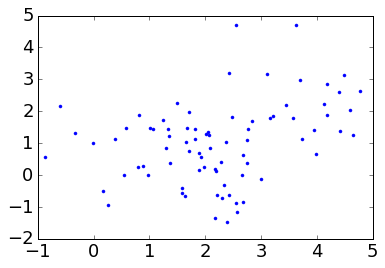

In [40]:
plt.plot(X[:, 0], X[:, 1], 'b.')

In [44]:
kstein = gof.KernelSteinTest(p, k, alpha=0.01)
kstein.perform_test(D)

{'alpha': 0.01,
 'h0_rejected': False,
 'n_simulate': 500,
 'pvalue': 0.19800000000000001,
 'test_stat': 7.1268087476653141,
 'time_secs': 0.03510403633117676}

## T distribution

In [47]:
stats.t.rvs(df=2, size=100)[:, np.newaxis]

array([[-0.87908096],
       [-0.15026574],
       [-3.29875157],
       [-5.53383718],
       [-3.43911094],
       [ 2.8883013 ],
       [ 3.59621931],
       [ 0.8697296 ],
       [ 1.21405264],
       [-0.73102322],
       [-0.55142736],
       [ 1.68957516],
       [ 0.14333762],
       [ 0.62751317],
       [ 0.34305654],
       [-2.25792764],
       [ 3.37418581],
       [ 0.8703625 ],
       [ 0.02772491],
       [-0.10468136],
       [ 0.01605984],
       [-0.09247375],
       [ 0.66212361],
       [-0.07547758],
       [ 4.51992048],
       [ 0.12490432],
       [-0.13253676],
       [-2.63278659],
       [-1.09262299],
       [-0.97793605],
       [ 2.30225629],
       [ 1.82481109],
       [ 0.15166613],
       [ 0.76415826],
       [-2.3094217 ],
       [ 0.24585178],
       [ 1.17783561],
       [ 0.12052428],
       [ 0.56549722],
       [-1.1828179 ],
       [ 0.10801365],
       [-0.85589054],
       [ 1.54098103],
       [ 1.74012283],
       [ 0.36036757],
       [-4